# EDA - влияние условий жизни нa успеваемость по математике.

Импортируем нужные для чтения и первичного анализа библиотеки и прочитаем файл.

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np

params = {'axes.facecolor': 'gainsboro',
          'axes.grid': True, 
          'grid.linestyle': '--',
          'axes.labelsize': 16,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)
%matplotlib inline

In [178]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
students = pd.read_csv('stud_math.csv')

## Содержание

1. [Первичный отсмотр данных](#1)
2. [Первичный анализ данных в строковых стобцах](#2)
3. [Корреляционный анализ](#3)
4. [Анализ номинативных переменных](#4)
5. [Выводы](#5)

***

## 1. Первичный отсмотр данных<a name="1"></a>

In [179]:
display(students.sample(5))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
301,GP,M,17,U,LE3,T,4.0,4.0,other,teacher,home,father,2.0,1.0,0.0,no,no,yes,no,yes,-3.0,yes,yes,no,4.0,1.0,1.0,5.0,0.0,50.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
374,MS,F,18,R,LE3,T,4.0,NaN,other,NaN,reputation,mother,2.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,95.0
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0


In [180]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В датасете 395 строк, 30 стобцов, из них 13 - числовые, 17 - строковые. В большинстве столбцов присутствуют пустые значения, но их количество не критичное. В дальнейшем проверим, можно ли заполнить пропуски. Так как по заданию __score__ - предсказываемая величина, сразу удалим строки с пропусками в это столбце:

In [181]:
students = students[students['score'].notnull()]

***

## 2. Первичный анализ данных в стобцах<a name="2"></a>

In [182]:
 students.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,382.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.627397,1.434903,2.036649,0.326975,-6.109948,3.930939,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,2.241790,0.692660,0.847239,0.729479,2.541716,0.931554,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [183]:
 students.describe(include='O')

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


На первый взгляд данные достаточно чистые. В столбце __absences__ наблюдается экстремальное максимальное значение. Также в столбцах __Fedu__ и __famrel__ наблюдаются данные, отличные от значений указанных в информации к датасету. В строковых столбцах не больше пяти уникальных значений. Напишем функции, которые покажут распредление признака по столбцам и процент пропусков:

In [184]:
def obj_get_colors(n):
    '''Функция для распределения цветов по кол-ву значений.'''
    colors = []
    cm = plt.cm.get_cmap('Blues', n)
    for i in np.arange(n):
        colors.append(cm(i))
    return colors

In [185]:
def obj_dict_sort(obj_dict):
    '''Функция для сортировки значений.'''
    keys = []
    values = []
    obj_dict = sorted(obj_dict.items(), key=lambda x: x[1])
    for key, value in obj_dict:
        keys.append(key)
        values.append(value)
    return (keys, values)

In [186]:
def obj_first_look(*args):
    '''Функция для строковых столбцов.
    
    Позволяет, как выводить единичный график,
    так и несколько графиков в отдельных полях.
    '''
    if type(args[0]) == list:
        args = args[0]

    fig = plt.figure(figsize=(20,7*((len(args)//3)+1)))
    gs = fig.add_gridspec((len(args)//3)+1, len(args) if len(args) <= 3 else 3)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i//3, i % 3])
        pct_missing = round(np.mean(students[args[i]].isnull())*100, 2) # Проверка на пропуски
        count = pd.value_counts(students[args[i]].values, sort=True)
        count_keys, count_values = obj_dict_sort(dict(count))
        values = len(count_keys)
        ax.set_ylim(0, max(count_values)+max(count_values)*0.20)
        ax.set_title(f'Распределение признака {args[i]}')
        ax.bar(np.arange(values), count_values, color=obj_get_colors(values))
        ax.set_ylabel('Количество')
        ax.set_xticks(np.arange(values))
        ax.set_xticklabels(count_keys)
        for i, value in enumerate(count_values):
            ax.text(i, value+0.5, value, horizontalalignment='center')
        ax.text(0, max(count_values)+max(count_values)*0.1,
                    f'Процент пропусков: {pct_missing}%', fontsize=14, bbox={'facecolor': 'w'})

In [187]:
def num_first_look(*args):
    '''Функция для числовых столбцов.'''
    if type(args[0]) == list:
        args = args[0]

    fig = plt.figure(figsize=(20,7*((len(args)//2)+1)))
    gs = fig.add_gridspec((len(args)//2)+1, len(args) if len(args) <= 2 else 2)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i//2, i % 2])
        counts, bins = np.histogram(students[args[i]].dropna())
        pct_missing = round(np.mean(students[args[i]].isnull())*100, 2)

        ax.set_title(f'Распределения признака {args[i]}')
        ax.hist(bins[:-1], bins, weights=counts, color='steelblue')
        ax.set_ylim(0, max(counts)+max(counts)*0.15)
        ax.text(students[args[i]].min(), max(counts)+max(counts)*0.06,
                f'Процент пропусков: {pct_missing}%', fontsize=14, bbox={'facecolor': 'w'})

Для начала посмотрим на предсказываемую переменную __score__:

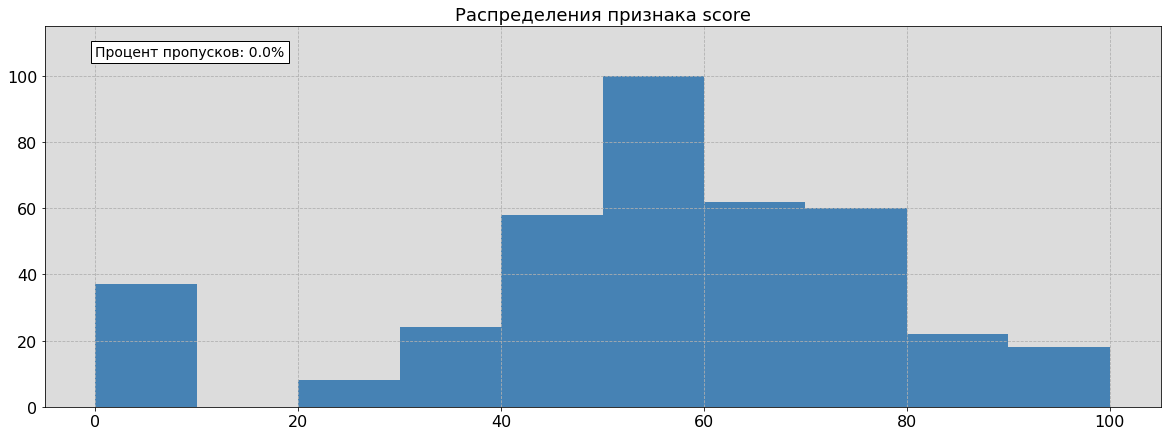

In [188]:
num_first_look('score')

Бросается в глаза большое количество оценок равных нулю в столбце __score__. Посмотрим внимательнее:

In [189]:
students['score'].value_counts().sort_index()

0.0      37
20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

Нули явно выходят за рамки нормального распределения и их можно считать выбросами. Так как __score__ - предсказываемая величина, лучше удалим их:

In [190]:
students = students[students['score'] != 0]

Теперь взглянем на строковые столбцы:

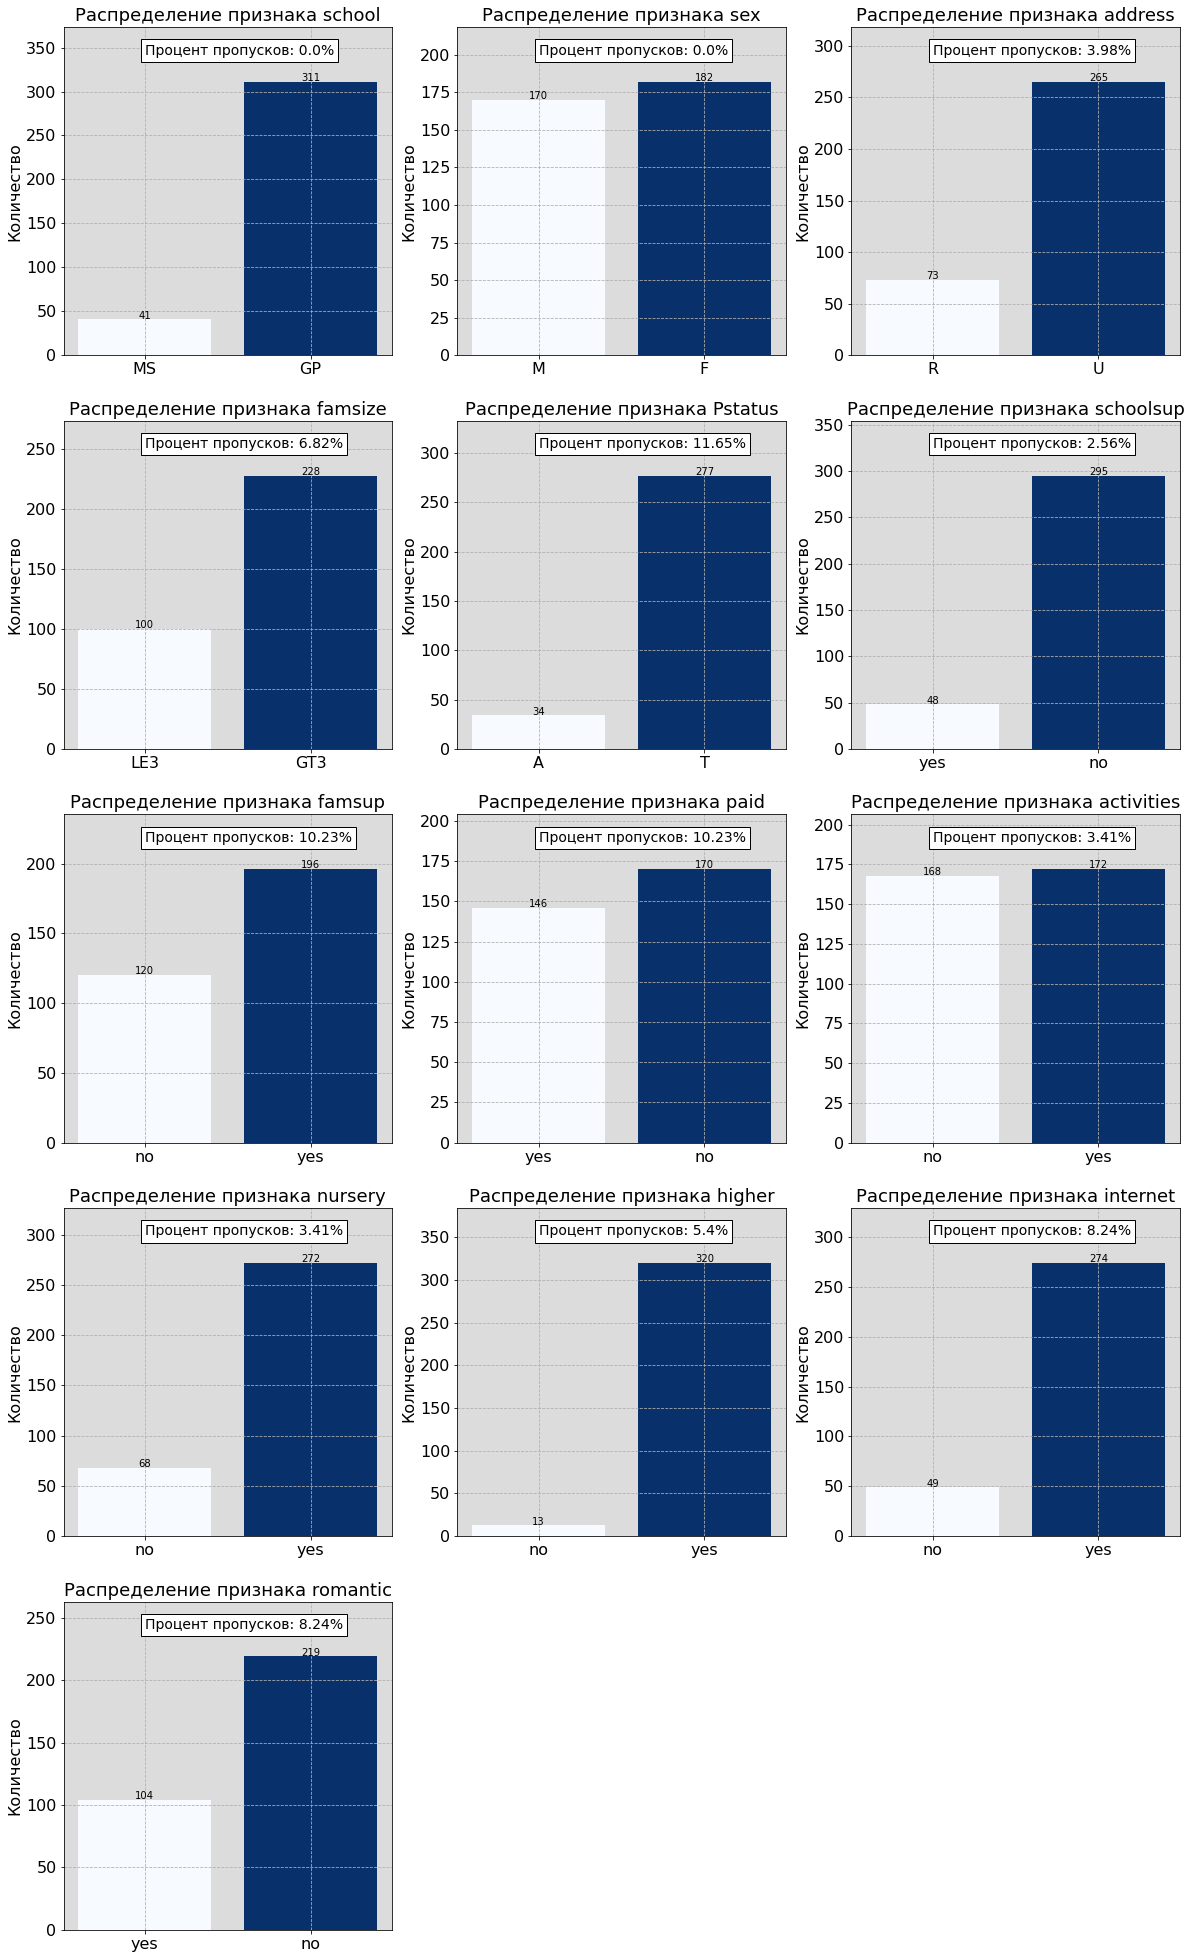

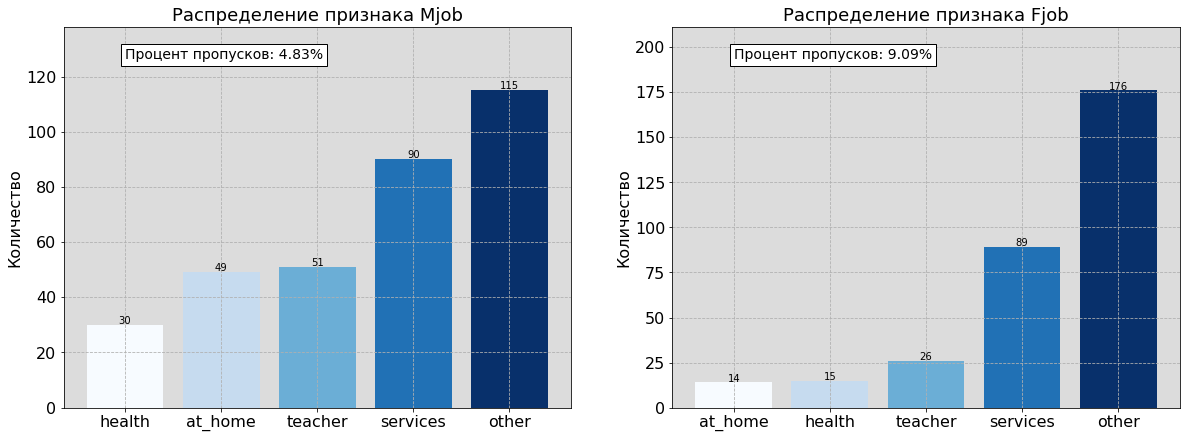

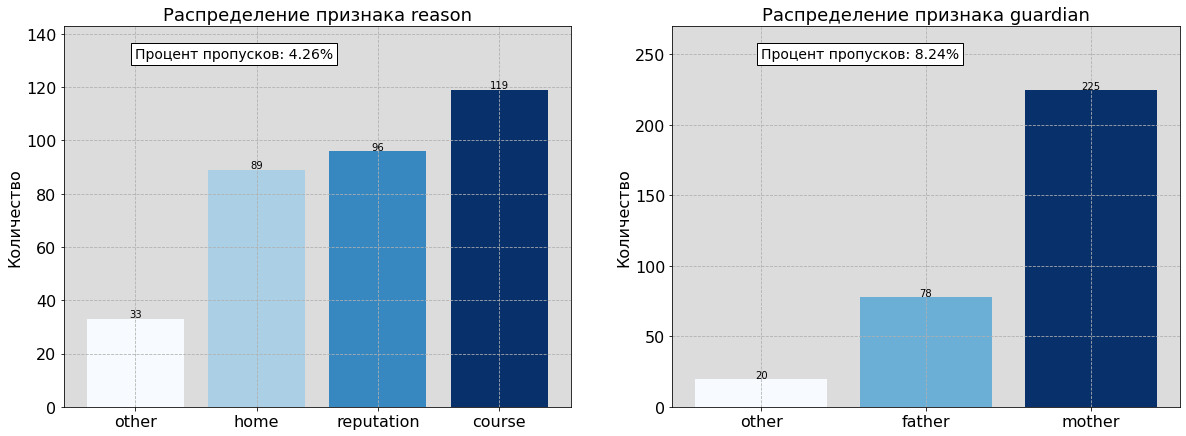

In [191]:
obj_first_look([col for col in students.columns if students[col].nunique(
) == 2 and students[col].dtype == 'O'])
obj_first_look([col for col in students.columns if students[col].nunique(
) == 5 and students[col].dtype == 'O'])
obj_first_look([col for col in students.columns if students[col].nunique(
) == 3 or students[col].nunique() == 4 and students[col].dtype == 'O'])

Доля пропусков небольшая - от 2% до 12%. Пропуски в столбцах с двумя значениями заменим модой:

In [192]:
for col in students.columns:
    if students[col].nunique() == 2 and students[col].dtype == 'O':
        students[col].fillna(students[col].mode()[0], inplace=True)

В оставшихся столбцах есть подходящее для замены пропусков значение __other__:

In [193]:
for col in students.columns:
    if students[col].nunique() != 2 and students[col].dtype == 'O':
        students[col].fillna('other', inplace=True)

Взглянем на числовые стобцы:

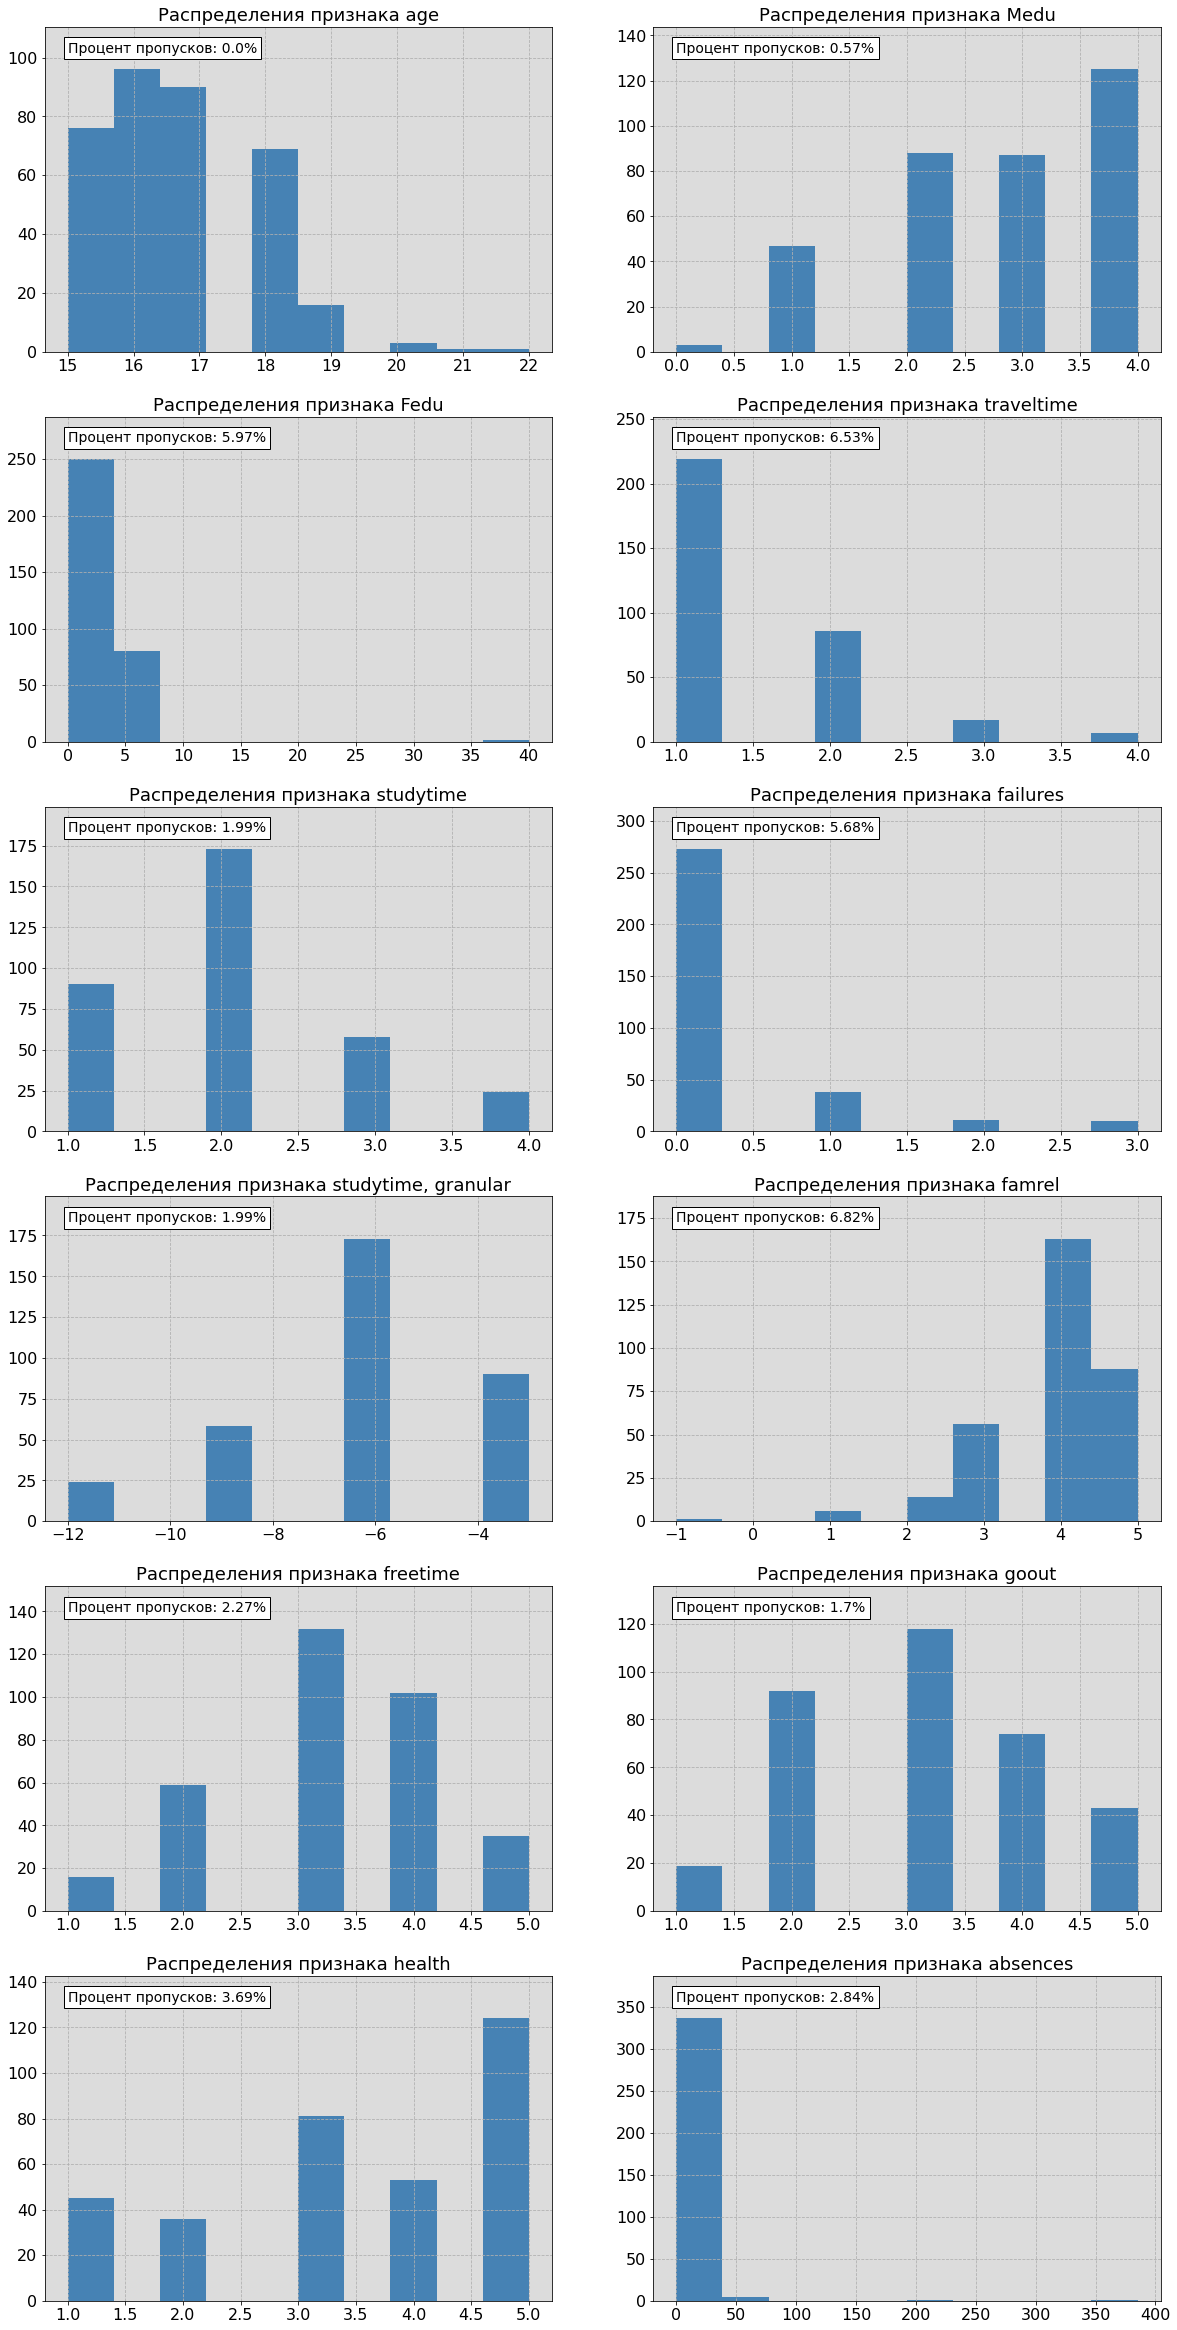

In [194]:
num_first_look([col for col in students.columns if students[col].name != 'score' and students[col].dtype != 'O'])

In [195]:
# if boundaries is not None: # Проверка на наличие выбросов
#     if students[(~students[col].between(boundaries[0], boundaries[1]))&
#                    pd.notnull(students[col])].shape[0] > 0:
#         print('Найдены выбросы:')
#         display(students[(~students[col].between(boundaries[0], boundaries[1]))&
#                    pd.notnull(students[col])])
#         print('----------------------------------')
#     else:
#         print('Выбросы не выявлены')

In [196]:
# num_first_look('age', boundaries=(15, 22))
# num_first_look('Medu', boundaries=(0, 4))
# num_first_look('Fedu', boundaries=(0, 4)), 
# num_first_look('traveltime', boundaries=(1, 4))
# num_first_look('studytime', boundaries=(1, 4))
# num_first_look('failures', boundaries=(0, 4))
# num_first_look('studytime, granular'), 
# num_first_look('famrel', boundaries=(1, 5))
# num_first_look('freetime', boundaries=(1, 5))
# num_first_look('goout', boundaries=(1, 5))
# num_first_look('health', boundaries=(1, 5)) 
# num_first_look('absences'), 
# num_first_look('score', boundaries=(0, 100))

In [197]:
perc25 = students.absences.quantile(0.25)
perc75 = students.absences.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль:', perc25)
print('75-й перцентиль:', perc75)
print('IQR:', IQR)

25-й перцентиль: 2.0
75-й перцентиль: 8.0
IQR: 6.0


***

## 3. Корреляционный анализ<a name="3"></a>

In [198]:
permutations_all = list(combinations(students.loc[:, 'sex'].dropna().unique(), 2))
for perm in permutations_all:
    print(ttest_ind(students.loc[students.loc[:, 'sex'] == perm[0], 'score'].dropna(), 
                    students.loc[students.loc[:, 'sex'] == perm[1], 'score'].dropna()).pvalue)

0.05481629433224236


In [199]:
cols = students['sex'].value_counts().index
pval = []
combinations_all = list(combinations(cols, 2))
for comb in combinations_all:
    pval.append(f_oneway(students.loc[students['sex'] == comb[0], 'score'], 
                         students.loc[students['sex'] == comb[1], 'score']).pvalue)
    pval.append(ttest_ind(students.loc[students['sex'] == comb[0], 'score'], 
                          students.loc[students['sex'] == comb[1], 'score']).pvalue)
np.array(pval)

array([0.05481629, 0.05481629])

In [200]:
cols = students['reason'].value_counts().index
arrays = []
for col in cols:
    arrays.append(students.loc[students['reason'] == col, 'score'])
f_oneway(*arrays)

F_onewayResult(statistic=0.4731356652976786, pvalue=0.7011918028806069)

In [201]:
students.loc[students['reason'] == 'home', 'score']

3      75.0
4      50.0
6      55.0
7      30.0
8      95.0
       ... 
372    55.0
375    50.0
378    75.0
380    70.0
384    25.0
Name: score, Length: 89, dtype: float64

In [202]:
cols = students['sex'].value_counts().index
f_oneway(students.loc[students['sex'] == cols[0], 'score'].dropna(), 
         students.loc[students['sex'] == cols[1], 'score'].dropna()).pvalue

0.054816294332250826

In [203]:
students.describe(include='O').iloc[1].unique()

array([2, 5, 4, 3], dtype=object)

In [204]:
students.loc[:, 'sex'].dropna().unique()

array(['F', 'M'], dtype=object)

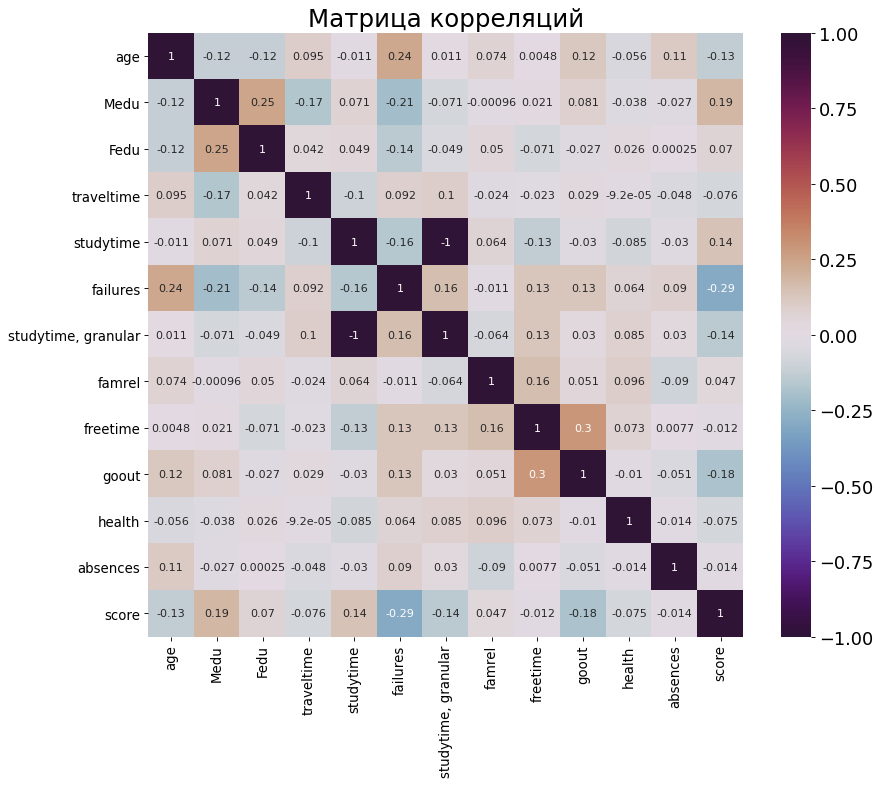

In [205]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(students.corr(), xticklabels=students.corr().columns,
            yticklabels=students.corr().columns, cmap='twilight_shifted', center=0, annot=True)

plt.title('Матрица корреляций', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

***

## 4. Анализ номинативных переменных<a name="4"></a>

In [206]:
def get_boxplot(*args):
    '''Функция позволяет, как выводить единичный график,
       так и несколько графиков в оотдельных полях'''
    if type(args[0]) == list:
        args = args[0]

    fig = plt.figure(figsize=(20,7*((len(args)//3)+1)))    
    gs = fig.add_gridspec((len(args)//3)+1, len(args) if len(args) <= 3 else 3)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i//3, i % 3])
        sns.boxplot(x=args[i], y='score', 
                data=students, palette="Blues")
        ax.set_title('Формы распределения для ' + args[i])
        
    plt.show()

In [207]:
def get_anova(*args):
    if type(args[0]) == list:
        args = args[0]
    
    for arg in args:
        values = students[arg].value_counts().index
        arrays = []
        for value in values:
            arrays.append(students.loc[students[arg] == value, 'score'].dropna())
        if f_oneway(*arrays).pvalue <= 0.05:
            print('Найдены статистически значимые различия для колонки', arg)

In [208]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'].dropna(), 
                        students.loc[students.loc[:, column] == comb[1], 'score'].dropna()).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

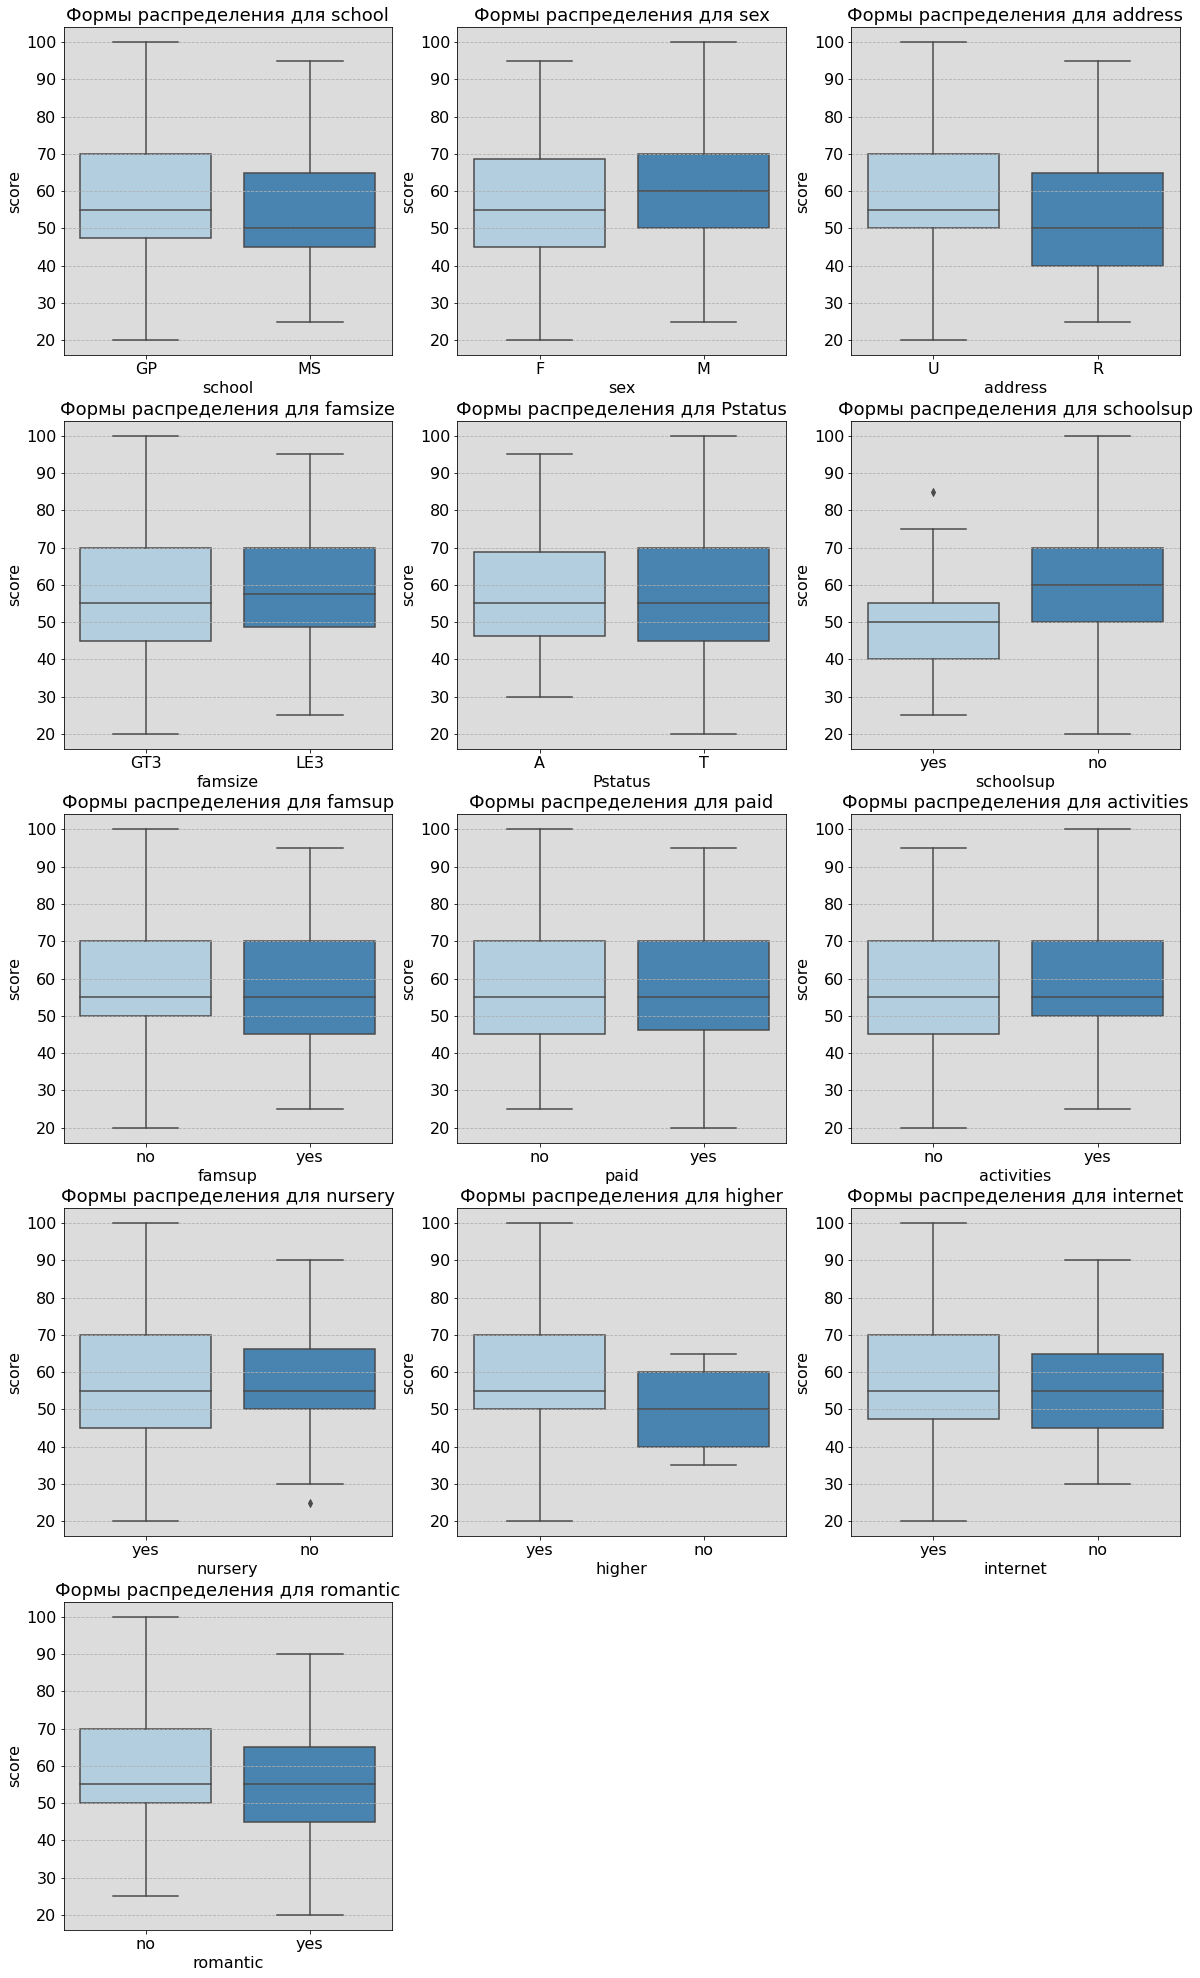

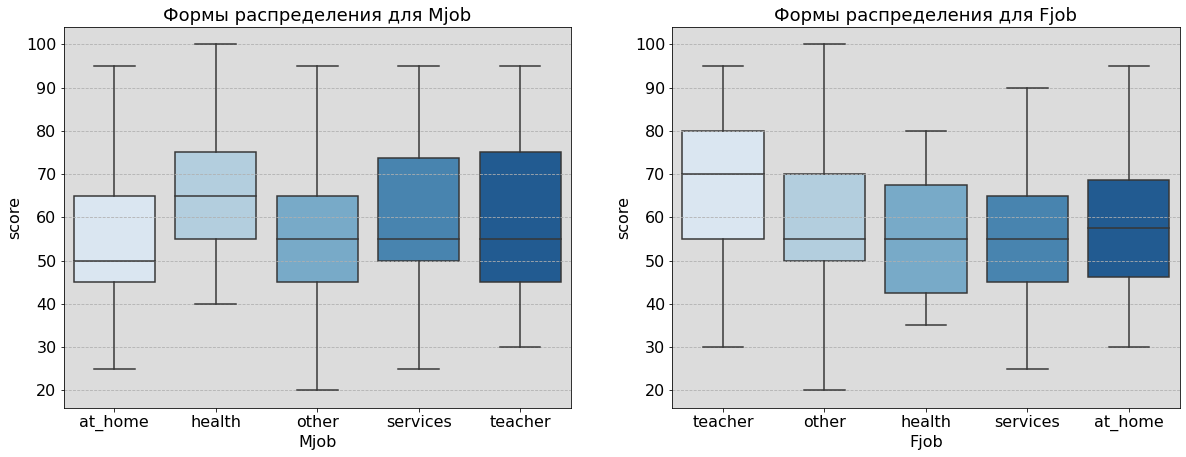

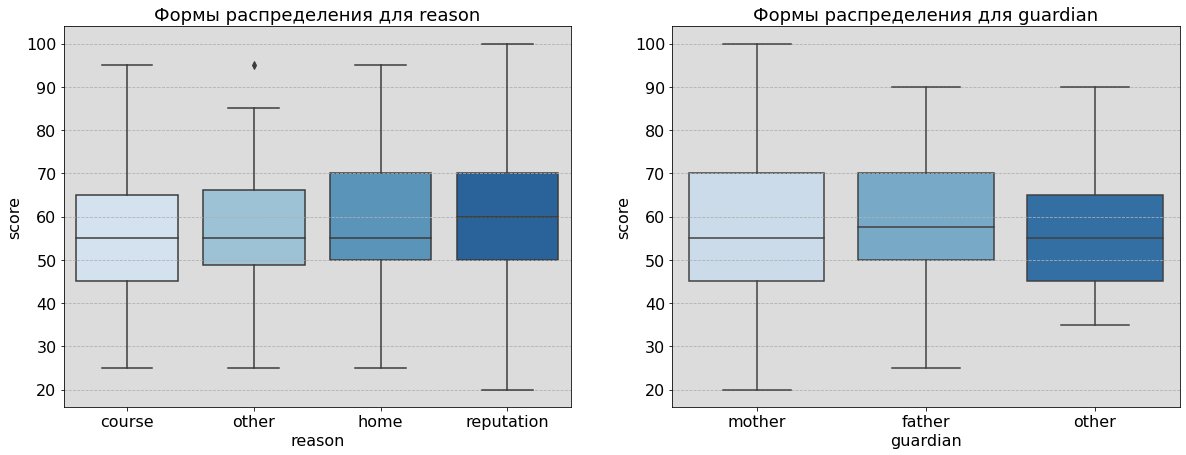

In [209]:
get_boxplot([col for col in students.columns if students[col].nunique(
) == 2 and students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if students[col].nunique(
) == 5 and students[col].dtype == 'O'])
get_boxplot([col for col in students.columns if students[col].nunique(
) == 3 or students[col].nunique() == 4 and students[col].dtype == 'O'])

In [210]:
for col in students.columns:
    if students[col].dtypes == 'O':
        get_anova(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки schoolsup


In [211]:
for col in students.columns:
    if students[col].dtypes == 'O':
        get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup


***

## 5. Выводы<a name="5"></a>

In [212]:
students[col].name

'score'